# Projeto 2 - Fine-Tuning de um modelo transformer para classificação de sentimento

In [302]:
%pip install -q -U watermark

Note: you may need to restart the kernel to use updated packages.


In [303]:
# %pip install -q transformers==4.46.3
# %pip install -q scikit-learn==1.5.2
# %pip install -q tokenizers==0.20.3
# %pip install -q numpy==1.26.2
# %pip install -q tqdm==4.65.0
# %pip install -q tensorflow==2.18.0
# %pip install -q keras==3.7.0
# %pip install -q spacy==3.7.2
# %pip install -q scipy==1.11.1
# %pip install -q nltk==3.8.1
# %pip install -q pandas==2.2.3
# %pip install -q keras-preprocessing==1.1.2
# %pip install -q matplotlib==3.7.4

In [304]:
# %watermark --iversions

In [305]:
# Imports

import math
import nltk
import spacy
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import transformers
from tokenizers import BertWordPieceTokenizer
from tqdm import tqdm
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from keras.api.utils import to_categorical
import keras
from keras.api.regularizers import l1_l2
from keras.api.models import Sequential
from keras.api.models import load_model
from keras_preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.api.metrics import Precision, Recall, AUC
from keras.api.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from keras.api.callbacks import EarlyStopping, LearningRateScheduler, CallbackList, ReduceLROnPlateau
from keras.api.optimizers import Adam


In [306]:
%reload_ext watermark
%watermark -a "Angelo Medeiros Nóbrega"

Author: Angelo Medeiros Nóbrega



# Carregando os dados de texto

In [307]:
# Carrega os dados de treino
dados_treino = pd.read_csv("dados_treino.txt", header=None, delimiter=";")

In [308]:
# Carrega os dados de teste
dados_teste = pd.read_csv("dados_teste.txt", header=None, delimiter=";")

In [309]:
# Ajusta os nomes das colunas
dados_treino = dados_treino.rename(columns={0: "texto", 1: "sentimento"})
dados_teste = dados_teste.rename(columns={0: "texto", 1: "sentimento"})

In [310]:
# Shape - Dados de treino
dados_treino.shape

(16000, 2)

In [311]:
# Shape - Dados de teste
dados_teste.shape

(2000, 2)

In [312]:
# Amostra de teste
dados_teste.head()

,texto,sentimento
0,i feel like my only role now would be to tear ...,sadness
1,i feel just bcoz a fight we get mad to each ot...,anger
2,i feel like reds and purples are just so rich ...,joy
3,im not sure the feeling of loss will ever go a...,sadness
4,i feel like ive gotten to know many of you thr...,joy


In [313]:
# Amostra de treino
dados_treino.head()

,texto,sentimento
0,i am feeling completely overwhelmed i have two...,fear
1,i have the feeling she was amused and delighted,joy
2,i was able to help chai lifeline with your sup...,joy
3,i already feel like i fucked up though because...,anger
4,i still love my so and wish the best for him i...,sadness


In [314]:
# Sentimentos presentes nos dados de treino
dados_treino["sentimento"].value_counts()

sentimento
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

In [315]:
# Sentimentos presentes nos dados de teste
dados_teste["sentimento"].value_counts()

sentimento
joy         695
sadness     581
anger       275
fear        224
love        159
surprise     66
Name: count, dtype: int64

# Pré-processamento dos dados de texto com SpaCy

In [316]:
!python -m spacy download en_core_web_md -q

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [317]:
# Carrega o dicionário
nlp = spacy.load("en_core_web_md")

In [318]:
# Definição da função `preprocessamento_texto` que recebe um texto como parâmetro
def preprocessamento_texto(text):
  # Processa o texto usando o dicionário
  doc = nlp(text)

  # Cria umalista de lemas dos tokens, convertidos para minúsculas e sem espaços em branco,
  # excluindo as palabras que são stopwords
  tokens = [token.lemma_.lower().strip() for token in doc if not token.is_stop]

  # Retorna os tokens processados como uma string única, unindo-os com espaços
  return ' '.join(tokens)

In [319]:
# Aplica a função em treino
dados_treino['texto_processado'] = dados_treino['texto'].apply(preprocessamento_texto)

In [320]:
# Aplica a função em teste
dados_teste['texto_processado'] = dados_teste['texto'].apply(preprocessamento_texto)

In [321]:
# Amostra dos dados de treino
dados_treino.head()

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


# Versao 1 do modelo - Arquitetura Fully Connected neural network

Vetorização serve para converter os dados de entrada em uma representação numérica. Ideal para textos muito simples onde o contexto não é tão relevante. Calcula a frequência de cada palavra em cada texto e cria um vetor com essas frequências.

Desvantagens do TF-IDF:
- Não consegue capturar o contexto;

## Passo 1: Vetorização com TF-IDF

In [322]:
tfidf = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

In [323]:
# Aplicar o vetorizador
dados_treino_tfidf = tfidf.fit_transform(dados_treino['texto_processado'])
dados_teste_tfidf = tfidf.transform(dados_teste['texto_processado'])

In [324]:
dados_treino_tfidf.shape

(16000, 5586)

In [325]:
dados_teste_tfidf.shape

(2000, 5586)

In [326]:
type(dados_treino_tfidf)

scipy.sparse._csr.csr_matrix

In [327]:
type(dados_teste_tfidf)

scipy.sparse._csr.csr_matrix

In [328]:
# Converte os dados de entrada (text) para array
X_treino_array = dados_treino_tfidf.toarray()
X_teste_array = dados_teste_tfidf.toarray()

type(X_treino_array)

numpy.ndarray

## Passo 2: Preparaçào dos dados


Precisamos agora converter a variável alvo para representaçào numérica. Para isso, vamos usar a função LabelEncoder do scikit-learn.

In [329]:
# Cria o label encoder
le = LabelEncoder()

In [330]:
# Faz o fit e transform na variável alvo em treino
y_treino_le = le.fit_transform(dados_treino['sentimento'])

In [331]:
# Faz o transform na variável alvo em teste
y_teste_le = le.transform(dados_teste['sentimento'])

Vamos tratar de forma automática o desbalanceamento de classe

In [332]:
# Peso das classes
pesos_classes = compute_class_weight('balanced', classes=np.unique(y_treino_le), y=y_treino_le)

In [333]:
np.unique(y_treino_le)

array([0, 1, 2, 3, 4, 5])

In [334]:
type(pesos_classes)

numpy.ndarray

In [335]:
print(pesos_classes)

[1.23513973 1.37669936 0.49732687 2.04498978 0.57151022 4.66200466]


### Validação

In [336]:
# Divisão em dados de treino e teste (validação)
X_treino, X_val, y_treino, y_val = train_test_split(X_treino_array, y_treino_le, test_size=0.2, random_state=42, stratify=y_treino_le)

In [337]:
# Ajusta a variável alvo como tipo categórica
y_treino_encoded = to_categorical(y_treino)
y_teste_encoded = to_categorical(y_teste_le)
y_val_encoded = to_categorical(y_val)

In [338]:
# Shapes
y_treino_encoded.shape, y_teste_encoded.shape, y_val_encoded.shape

((12800, 6), (2000, 6), (3200, 6))

# Passo 3: Construção do modelo

In [339]:
# Cria o modelo

# Inicializa um modelo sequencial. Modelos sequencias sao uma pilha linear de camadas.
model_v1 = Sequential()

# Define o número de colunas do X_treino
numero_de_colunas_X_treino = X_treino.shape[1]

# Adiciona a primeira camada densa (Fully-connected) ao modelo
model_v1.add(
    Dense(
        4096,
        # Utiliza a funcao de ativacao SELU (Scaled Exponential Linear Unit)
        activation='selu',

        # Inicializa os pesos com a distribuicao LeCun Normal
        kernel_initializer='lecun_normal',

        # Define o formato da entrada com base no número de features do X_treino
        input_shape=(numero_de_colunas_X_treino,),

        # Aplica regularização L2 para reduzir o overfitting
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )
)

# Adiciona a segunda camada densa
model_v1.add(
    Dense(
        2048,
        activation='selu',
        kernel_initializer='lecun_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )
)

# Adiciona a terceira camada densa
model_v1.add(
    Dense(
        1024,
        activation='selu',
        kernel_initializer='lecun_normal',
        kernel_regularizer=tf.keras.regularizers.l2(0.01)
    )
)

# Adiciona a quarta camada densa
# Camada com 64 neurônios e ativacao SELU
model_v1.add(
    Dense(
        64,
        activation='selu',
    )
)

# Adiciona a camada de saída
# Camada com 6 neurônios e ativacao softmax para classificação multiclasse
model_v1.add(Dense(6, activation='softmax'))

# O número de neuronios de cada camada é definido a partir de testes e experimentações.
# Não existe uma regra fixa para definir o número de neurônios de cada camada.
# O número de camadas e neurônios é um hiperparâmetro que deve ser ajustado de acordo com o problema.

c:\Users\angel\anaconda3\envs\dsa-formacao-ia\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# Passo 4: Compilação e Sumário do Modelo

In [340]:
# Atribui pesos específicos ao betor de bias da última camada do modelo
model_v1.layers[-1].bias.assign(pesos_classes)

<tf.Tensor: shape=(6,), dtype=float32, numpy=
array([1.2351397 , 1.3766993 , 0.49732688, 2.0449898 , 0.5715102 ,
       4.6620045 ], dtype=float32)>

#### Compila o odelo

- Define o otimizador Adam.

   Adam é um algortimo de otimização que pode ser usado no lugar do procedimento 
   clássico de descida do gradiente estocástico para atualizar os pesos da rede e minimizar a função de perda.

In [341]:
model_v1.compile(optimizer='Adam', loss=tf.losses.categorical_crossentropy, metrics=['accuracy', Precision(), Recall(), AUC()])

In [342]:
model_v1.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 4096)           │    22,884,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,439,174 (127.56 MB)

 Trainable params: 33,439,174 (127.56 MB)

 Non-trainable params: 0 (0.00 B)

# Passo 5: Callbacks e Early Stopping

In [343]:
# Funcao para os paramentros de scheduler da taxa de aprendizado
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

In [344]:
# Scheduler da taxa de aprendizado
ls_scheduler = LearningRateScheduler(step_decay)

In [345]:
# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

# Passo 6: Treinamento do Modelo

In [346]:
# Hiperparâmetros
num_epochs = 20
tamanho_batch = 256

In [347]:
%%time
history = model_v1.fit(
    X_treino,
    y_treino_encoded,
    validation_data=(X_val, y_val_encoded),
    epochs=num_epochs,
    batch_size=tamanho_batch,
    callbacks=[ls_scheduler, early_stopping]
)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 368ms/step - accuracy: 0.5083 - auc_5: 0.7970 - loss: 33.6329 - precision_5: 0.6134 - recall_5: 0.3572 - val_accuracy: 0.8072 - val_auc_5: 0.9673 - val_loss: 1.9581 - val_precision_5: 0.8699 - val_recall_5: 0.7206 - learning_rate: 0.0010
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 369ms/step - accuracy: 0.8419 - auc_5: 0.9776 - loss: 1.5062 - precision_5: 0.8883 - recall_5: 0.7860 - val_accuracy: 0.8213 - val_auc_5: 0.9719 - val_loss: 1.2489 - val_precision_5: 0.8673 - val_recall_5: 0.7681 - learning_rate: 0.0010
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 366ms/step - accuracy: 0.8756 - auc_5: 0.9848 - loss: 1.0628 - precision_5: 0.9065 - recall_5: 0.8331 - val_accuracy: 0.8094 - val_auc_5: 0.9699 - val_loss: 1.2100 - val_precision_5: 0.8428 - val_recall_5: 0.7659 - learning_rate: 0.0010
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.8970 - auc_5: 0.9884 - loss: 0.9602 - precision_5: 0.9239 - recall_5: 0.8683 - val_accuracy: 0.

# Passo 7: Avaliação do Modelo

In [348]:
# Extrai o erro em treino e validaçao
loss, val_loss = history.history['loss'], history.history['val_loss']

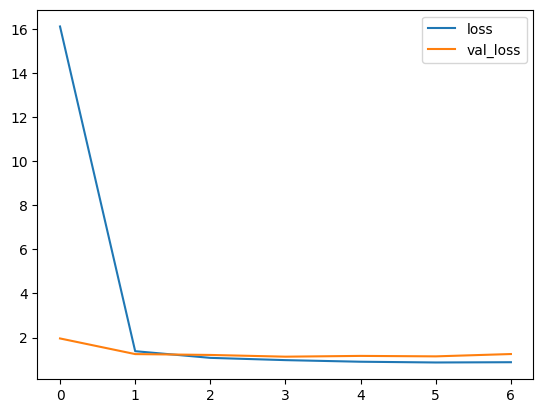

In [349]:
# Plot
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()


In [350]:
# Previsões com dados de teste
previsoes_v1 = model_v1.predict(X_teste_array)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [351]:
# Extrai os labels
previsoes_v1_labels = previsoes_v1.argmax(axis=1)

In [352]:
print(classification_report(y_teste_le, previsoes_v1_labels))

              precision    recall  f1-score   support

           0       0.88      0.76      0.81       275
           1       0.86      0.72      0.78       224
           2       0.88      0.87      0.87       695
           3       0.63      0.75      0.69       159
           4       0.82      0.91      0.87       581
           5       0.66      0.56      0.61        66

    accuracy                           0.83      2000
   macro avg       0.79      0.76      0.77      2000
weighted avg       0.83      0.83      0.83      2000



In [353]:
# Matriz de confusão
confusion_matrix(y_teste_le, previsoes_v1_labels)

array([[208,   6,  10,   9,  40,   2],
       [ 12, 161,  10,   0,  28,  13],
       [  3,   4, 604,  49,  33,   2],
       [  1,   1,  26, 120,  10,   1],
       [ 12,   3,  26,   9, 530,   1],
       [  1,  12,  12,   2,   2,  37]], dtype=int64)

In [354]:
# Acurácia
accuracy_score(y_teste_le, previsoes_v1_labels)

0.83

In [355]:
# Salva o modelo
model_v1.save("model_v1.keras")

# Passo 8: Deploy da Versão 1 do modelo

In [356]:
# Carrega o modelo
modelo_carregado = load_model("model_v1.keras")

In [357]:
# Nova frase (sentimento medo [fear])
frase1 = "I'm afraid of the dark"
# Nova frase (sentimento medo [fear])
frase2 = "I even feel a little shaky"
# Nova frase (sentimento medo [happy])
frase3 = "I am very happy today"

frases = [frase1, frase2, frase3]

In [358]:
# Cria um dataframe com a nova frase
df_novo = pd.DataFrame(frases)

In [359]:
# Aplica a função de preprocessamento
df_novo['Frase_Processada'] = df_novo[0].apply(preprocessamento_texto)

In [360]:
df_novo

,0,Frase_Processada
0,I'm afraid of the dark,afraid dark
1,I even feel a little shaky,feel little shaky
2,I am very happy today,happy today


In [361]:
# Aplica a vetorização
df_novo_tfidf = tfidf.transform(df_novo['Frase_Processada'])

In [362]:
# Transforma em array
df_novo_array = df_novo_tfidf.toarray()

In [363]:
# Previsões
previsoes_novo = modelo_carregado.predict(df_novo_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


In [364]:
previsoes_novo

array([[6.30481495e-03, 9.43214774e-01, 6.54509431e-03, 3.67464905e-04,
        1.10131940e-02, 3.25546637e-02],
       [1.45121582e-03, 9.76917028e-01, 1.47228490e-03, 5.02761031e-05,
        1.10232411e-02, 9.08591039e-03],
       [1.51466625e-02, 4.67678066e-03, 9.14451778e-01, 2.35542413e-02,
        4.08967659e-02, 1.27387710e-03]], dtype=float32)

In [365]:
# Seleciona a classe com maior probabilidade
classe_maior_prob = previsoes_novo.argmax(axis=1)

In [366]:
classe_maior_prob

array([1, 1, 2], dtype=int64)

In [367]:
# Obtem os nomes das classes
classes = le.inverse_transform(classe_maior_prob)

In [368]:
classes

array(['fear', 'fear', 'joy'], dtype=object)

___

# Versão 2 do modelo - Arquitetura LSTM (Long Short-Term Memory)

In [432]:
# Dados processados com SpaCy
dados_treino.head()

,texto,sentimento,texto_processado
0,i am feeling completely overwhelmed i have two...,fear,feel completely overwhelmed strategy help feel...
1,i have the feeling she was amused and delighted,joy,feeling amuse delight
2,i was able to help chai lifeline with your sup...,joy,able help chai lifeline support encouragement ...
3,i already feel like i fucked up though because...,anger,feel like fuck not usually eat morning
4,i still love my so and wish the best for him i...,sadness,love wish good long tolerate effect bm life fa...


In [433]:
tokenizador = Tokenizer()

In [434]:
# Ajuste do tokenizador com os textos processados
tokenizador.fit_on_texts(dados_treino['texto_processado'])

In [435]:
# Criação do índice de palavras
word_index = tokenizador.word_index

In [436]:
len(word_index)

11896

In [437]:
word_index.items()

dict_items([('feel', 1), ('like', 2), ('m', 3), ('not', 4), ('feeling', 5), ('know', 6), ('time', 7), ('t', 8), ('want', 9), ('think', 10), ('s', 11), ('ve', 12), ('little', 13), ('go', 14), ('love', 15), ('day', 16), ('thing', 17), ('people', 18), ('life', 19), ('way', 20), ('need', 21), ('bit', 22), ('get', 23), ('good', 24), ('work', 25), ('start', 26), ('come', 27), ('look', 28), ('try', 29), ('make', 30), ('pretty', 31), ('don', 32), ('leave', 33), ('find', 34), ('right', 35), ('friend', 36), ('help', 37), ('year', 38), ('today', 39), ('tell', 40), ('say', 41), ('write', 42), ('lot', 43), ('happy', 44), ('long', 45), ('hate', 46), ('week', 47), ('sure', 48), ('read', 49), ('kind', 50), ('away', 51), ('home', 52), ('well', 53), ('person', 54), ('take', 55), ('talk', 56), ('remember', 57), ('d', 58), ('bad', 59), ('world', 60), ('actually', 61), ('let', 62), ('new', 63), ('have', 64), ('family', 65), ('http', 66), ('care', 67), ('end', 68), ('post', 69), ('hope', 70), ('moment', 71)

In [438]:
# Itera sobre os pares Chave-Valor do dicionário
for i, (chave, valor) in enumerate(word_index.items()):
    print(chave, valor)
    if i == 10:
        break

feel 1
like 2
m 3
not 4
feeling 5
know 6
time 7
t 8
want 9
think 10
s 11


In [439]:
sequencias_treino = tokenizador.texts_to_sequences(dados_treino['texto_processado'])

In [440]:
max_length = 100

In [441]:
# Padding das sequências de treino
sequencias_treino_pad = pad_sequences(sequencias_treino, maxlen=max_length, truncating='post')	

In [442]:
sequencias_teste = tokenizador.texts_to_sequences(dados_teste['texto_processado'])

In [443]:
sequencias_teste_pad = pad_sequences(sequencias_teste, maxlen=max_length)

In [444]:
len_v2 = LabelEncoder()

In [445]:
y_treino_le = len_v2.fit_transform(dados_treino['sentimento'])

In [446]:
y_teste_le = len_v2.transform(dados_teste['sentimento'])

In [447]:
y_treino_encoded = to_categorical(y_treino_le)
y_teste_encoded = to_categorical(y_teste_le)

In [448]:
vocab_size = len(word_index) + 1

In [449]:
vocab_size

11897

In [464]:
embedding_dim = max_length

In [503]:
model_v2 = tf.keras.Sequential([
    Embedding(vocab_size, embedding_dim, input_length=max_length),
    Bidirectional(LSTM(64)),
    Dropout(0.4),
    Dense(32, activation = 'leaky_relu', kernel_regularizer=l1_l2(l1 = 0.01,l2 = 0.01)),
    Dropout(0.4),
    Dense(6, activation='softmax')
])

c:\Users\angel\anaconda3\envs\dsa-formacao-ia\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [504]:
model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', Precision(), Recall(), AUC()])

In [511]:
print(model_v2.summary())

Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_32 (Embedding)        │ (32, 100, 100)         │     1,189,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_32                │ (32, 128)              │        84,480 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (32, 32)               │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (32, 32)               │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_62 (Dense)                │ (32, 6)                │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,835,520 (14.63 MB)

 Trainable params: 1,278,506 (4.88 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,557,014 (9.75 MB)

None


In [506]:
dados_entrada = np.array(sequencias_treino_pad)

In [507]:
dados_saida = np.array(y_treino_encoded)

In [508]:
num_epochs = 35
validation_split = 0.2
paciencia = 5

In [509]:
early_stopping = EarlyStopping(patience=paciencia)

In [512]:
history_v2 = model_v2.fit(
    dados_entrada,
    dados_saida,
    epochs=num_epochs,
    validation_split=validation_split,
    callbacks=[early_stopping]
)

Epoch 1/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - accuracy: 0.3410 - auc_14: 0.7790 - loss: 1.5040 - precision_14: 0.4774 - recall_14: 0.0622 - val_accuracy: 0.4206 - val_auc_14: 0.8548 - val_loss: 1.2722 - val_precision_14: 0.5313 - val_recall_14: 0.2309
Epoch 2/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step - accuracy: 0.4499 - auc_14: 0.8697 - loss: 1.2011 - precision_14: 0.5395 - recall_14: 0.2113 - val_accuracy: 0.4391 - val_auc_14: 0.8638 - val_loss: 1.2195 - val_precision_14: 0.5055 - val_recall_14: 0.2734
Epoch 3/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 32ms/step - accuracy: 0.4585 - auc_14: 0.8793 - loss: 1.1209 - precision_14: 0.5391 - recall_14: 0.2369 - val_accuracy: 0.4578 - val_auc_14: 0.8715 - val_loss: 1.1668 - val_precision_14: 0.5098 - val_recall_14: 0.2434
Epoch 4/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.5001 - auc_14: 0.8914 - loss: 1.0446 - precision_14: 0.5443 - recall_14: 0.2636 - val_accuracy: 0.4822 - val_auc_14: 0.8842 - val_loss: 1.0882 - v

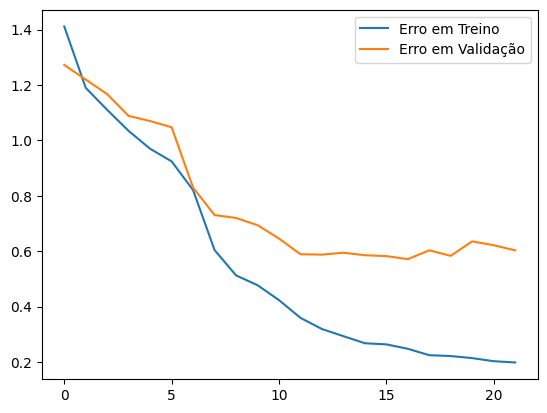

In [513]:
loss, val_loss = history_v2.history['loss'], history_v2.history['val_loss']
plt.plot(loss, label = 'Erro em Treino')
plt.plot(val_loss, label = 'Erro em Validação')
plt.legend()
plt.show()

In [514]:
previsoes_v2 = model_v2.predict(sequencias_teste_pad)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


In [515]:
labels_previsoes_v2 = previsoes_v2.argmax(axis=1)

In [516]:
print(classification_report(y_teste_le, labels_previsoes_v2))

              precision    recall  f1-score   support

           0       0.89      0.87      0.88       275
           1       0.86      0.85      0.86       224
           2       0.91      0.93      0.92       695
           3       0.77      0.75      0.76       159
           4       0.94      0.92      0.93       581
           5       0.65      0.74      0.70        66

    accuracy                           0.89      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.89      0.89      0.89      2000



In [517]:
print(confusion_matrix(y_teste_le, labels_previsoes_v2))

[[240  11   4   3  17   0]
 [ 11 191   1   0   3  18]
 [  3   3 648  27   7   7]
 [  2   1  32 119   4   1]
 [ 14   9  19   4 535   0]
 [  0   6   7   2   2  49]]


In [518]:
print(accuracy_score(y_teste_le, labels_previsoes_v2))

0.891


In [519]:
model_v2.save("model_v2.keras")

In [520]:
model_v2_carregado = load_model("model_v2.keras")

In [521]:
df_novo_v2 = pd.DataFrame({ 'Frase': frases })

In [522]:
df_novo_v2['Frase_Processada'] = df_novo_v2['Frase'].apply(preprocessamento_texto)

In [523]:
sequencias_novas = tokenizador.texts_to_sequences(df_novo_v2['Frase_Processada'])

In [524]:
sequecias_novas_pad = pad_sequences(sequencias_novas, maxlen=max_length)

In [525]:
previsoes_v2 = model_v2_carregado.predict(sequecias_novas_pad)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step


In [527]:
previsoes_v2
classe_maior_prob_v2 = previsoes_v2.argmax(axis=1)
classe_maior_prob_v2
classes_v2 = len_v2.inverse_transform(classe_maior_prob_v2)
classes_v2

array(['fear', 'fear', 'joy'], dtype=object)